In [1]:
import os

import pandas as pd
import numpy as np

from PIL import Image
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import Sequential, Input
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras.models import load_model

In [2]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

In [3]:
# Load the training files
train_ds = keras.utils.image_dataset_from_directory(
    'D:/Dataset/data/Train',
    labels = 'inferred',
    seed = 42,
    image_size = (256,256),
    batch_size = 32)

# Load the testing files
val_ds = keras.utils.image_dataset_from_directory(
    'D:/Dataset/data/Test',
    labels = 'inferred',
    seed = 42,
    image_size=(256,256),
    batch_size=32
)

# Get class labels
class_labels = train_ds.class_names

Found 16740 files belonging to 62 classes.
Found 3720 files belonging to 62 classes.


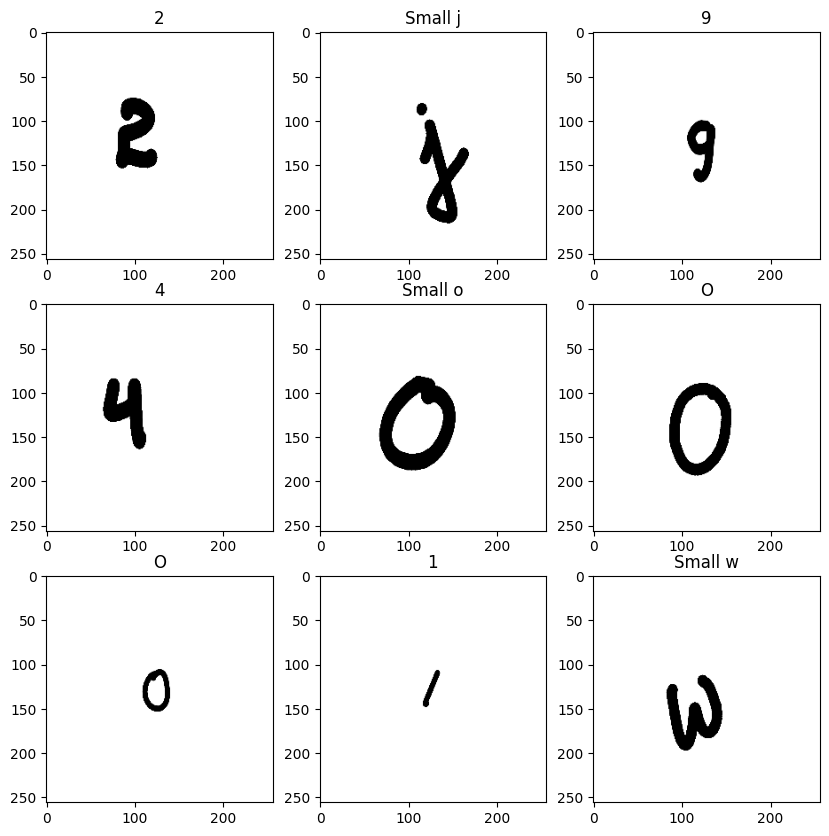

In [25]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_labels[labels[i]])

In [26]:
# Normalize the images

def normalize_image(image,label):
    new_image = tf.cast(image/255., tf.float32)
    return new_image,label

train_ds = train_ds.map(normalize_image)
val_ds = val_ds.map(normalize_image)

In [27]:
# Denormalize the image to display the test image

def denormalize_image(image):
    new_image = tf.cast(image*255., tf.float32)
    return new_image

In [28]:
# prepare the image for testing

def preprocess_test_img(image):
    denorm_img = denormalize_image(image)
    input_img = image.reshape((1,256,256,3))
    return denorm_img, input_img

### Best Model

In [14]:
# Create the model

model = Sequential()

model.add(Conv2D(32, kernel_size=(5,5), padding = 'valid', activation = 'relu', input_shape = (256,256,3)))
model.add(MaxPooling2D(pool_size=(5,5), strides = 5, padding = 'valid'))

model.add(Conv2D(64, kernel_size=(5,5), padding = 'valid', activation = 'relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(5,5), strides = 5, padding = 'valid'))

model.add(Conv2D(128, kernel_size=(5,5), padding = 'valid', activation = 'relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(5,5), strides = 5, padding = 'valid'))

model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(62, activation = 'softmax'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 252, 252, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 46, 46, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 5, 5, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 62)             │         7,998 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 334,078 (1.27 MB)

 Trainable params: 333,310 (1.27 MB)

 Non-trainable params: 768 (3.00 KB)

In [15]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.05,patience=3, min_lr=0.000001)

es = EarlyStopping(monitor='val_accuracy',restore_best_weights=True, patience = 5)

history = model.fit(train_ds, epochs = 100, validation_data=val_ds, callbacks=[es, reduce_lr])

Epoch 1/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 155s 290ms/step - accuracy: 0.0216 - loss: 4.5299 - val_accuracy: 0.0164 - val_loss: 6.2360 - learning_rate: 0.0010
Epoch 2/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 153s 292ms/step - accuracy: 0.2472 - loss: 2.7784 - val_accuracy: 0.4949 - val_loss: 1.6545 - learning_rate: 0.0010
Epoch 3/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 153s 291ms/step - accuracy: 0.5459 - loss: 1.4876 - val_accuracy: 0.6301 - val_loss: 1.2321 - learning_rate: 0.0010
Epoch 4/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 154s 294ms/step - accuracy: 0.6439 - loss: 1.1325 - val_accuracy: 0.6898 - val_loss: 1.0077 - learning_rate: 0.0010
Epoch 5/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 154s 294ms/step - accuracy: 0.7010 - loss: 0.9196 - val_accuracy: 0.7242 - val_loss: 0.8783 - learning_rate: 0.0010
Epoch 6/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 154s 294ms/step - accuracy: 0.7496 - loss: 0.7583 - val_accuracy: 0.7159 - val_loss: 0.9840 - learning_rate: 0.0010
Epoch 7/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 154s 294ms/step -

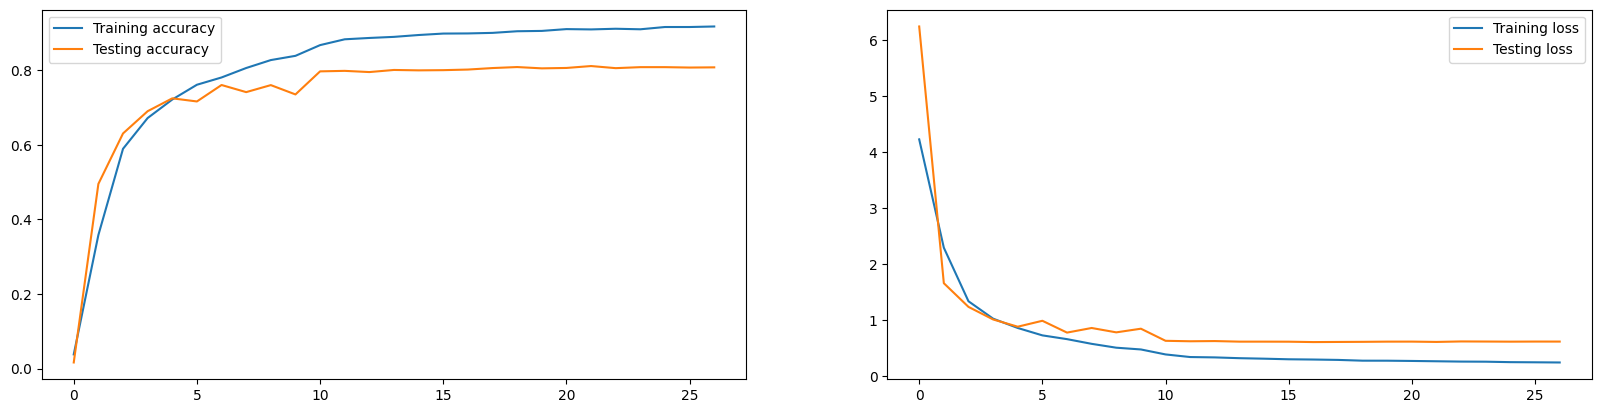

In [16]:
fig,axes = plt.subplots(1,2)
fig.set_figwidth(20)

axes[0].plot(history.history['accuracy'],label = 'Training accuracy')
axes[0].plot(history.history['val_accuracy'],label = 'Testing accuracy')
axes[0].legend(loc = 'best')

axes[1].plot(history.history['loss'],label = 'Training loss')
axes[1].plot(history.history['val_loss'],label = 'Testing loss')
axes[1].legend(loc = 'best')

plt.show()

In [17]:
model.save('best_model.keras')

## Test Prediction

In [18]:
def display_predictions(img_data, target_labels,i,ax):
    
    denorm_img, input_img = preprocess_test_img(img_data[i].numpy())

    y_true = class_labels[target_labels[i].numpy()]

    ind = np.argmax(model.predict(input_img,verbose=False))

    y_pred = class_labels[ind]

    ax.imshow(denorm_img.numpy().astype('uint8'))
    if y_pred == y_true:
        ax.set_title('Prediction: {}'.format(y_pred),color = 'green')
    else:
        ax.set_title('Prediction: {}, True : {}'.format(y_pred,y_true),color = 'red')

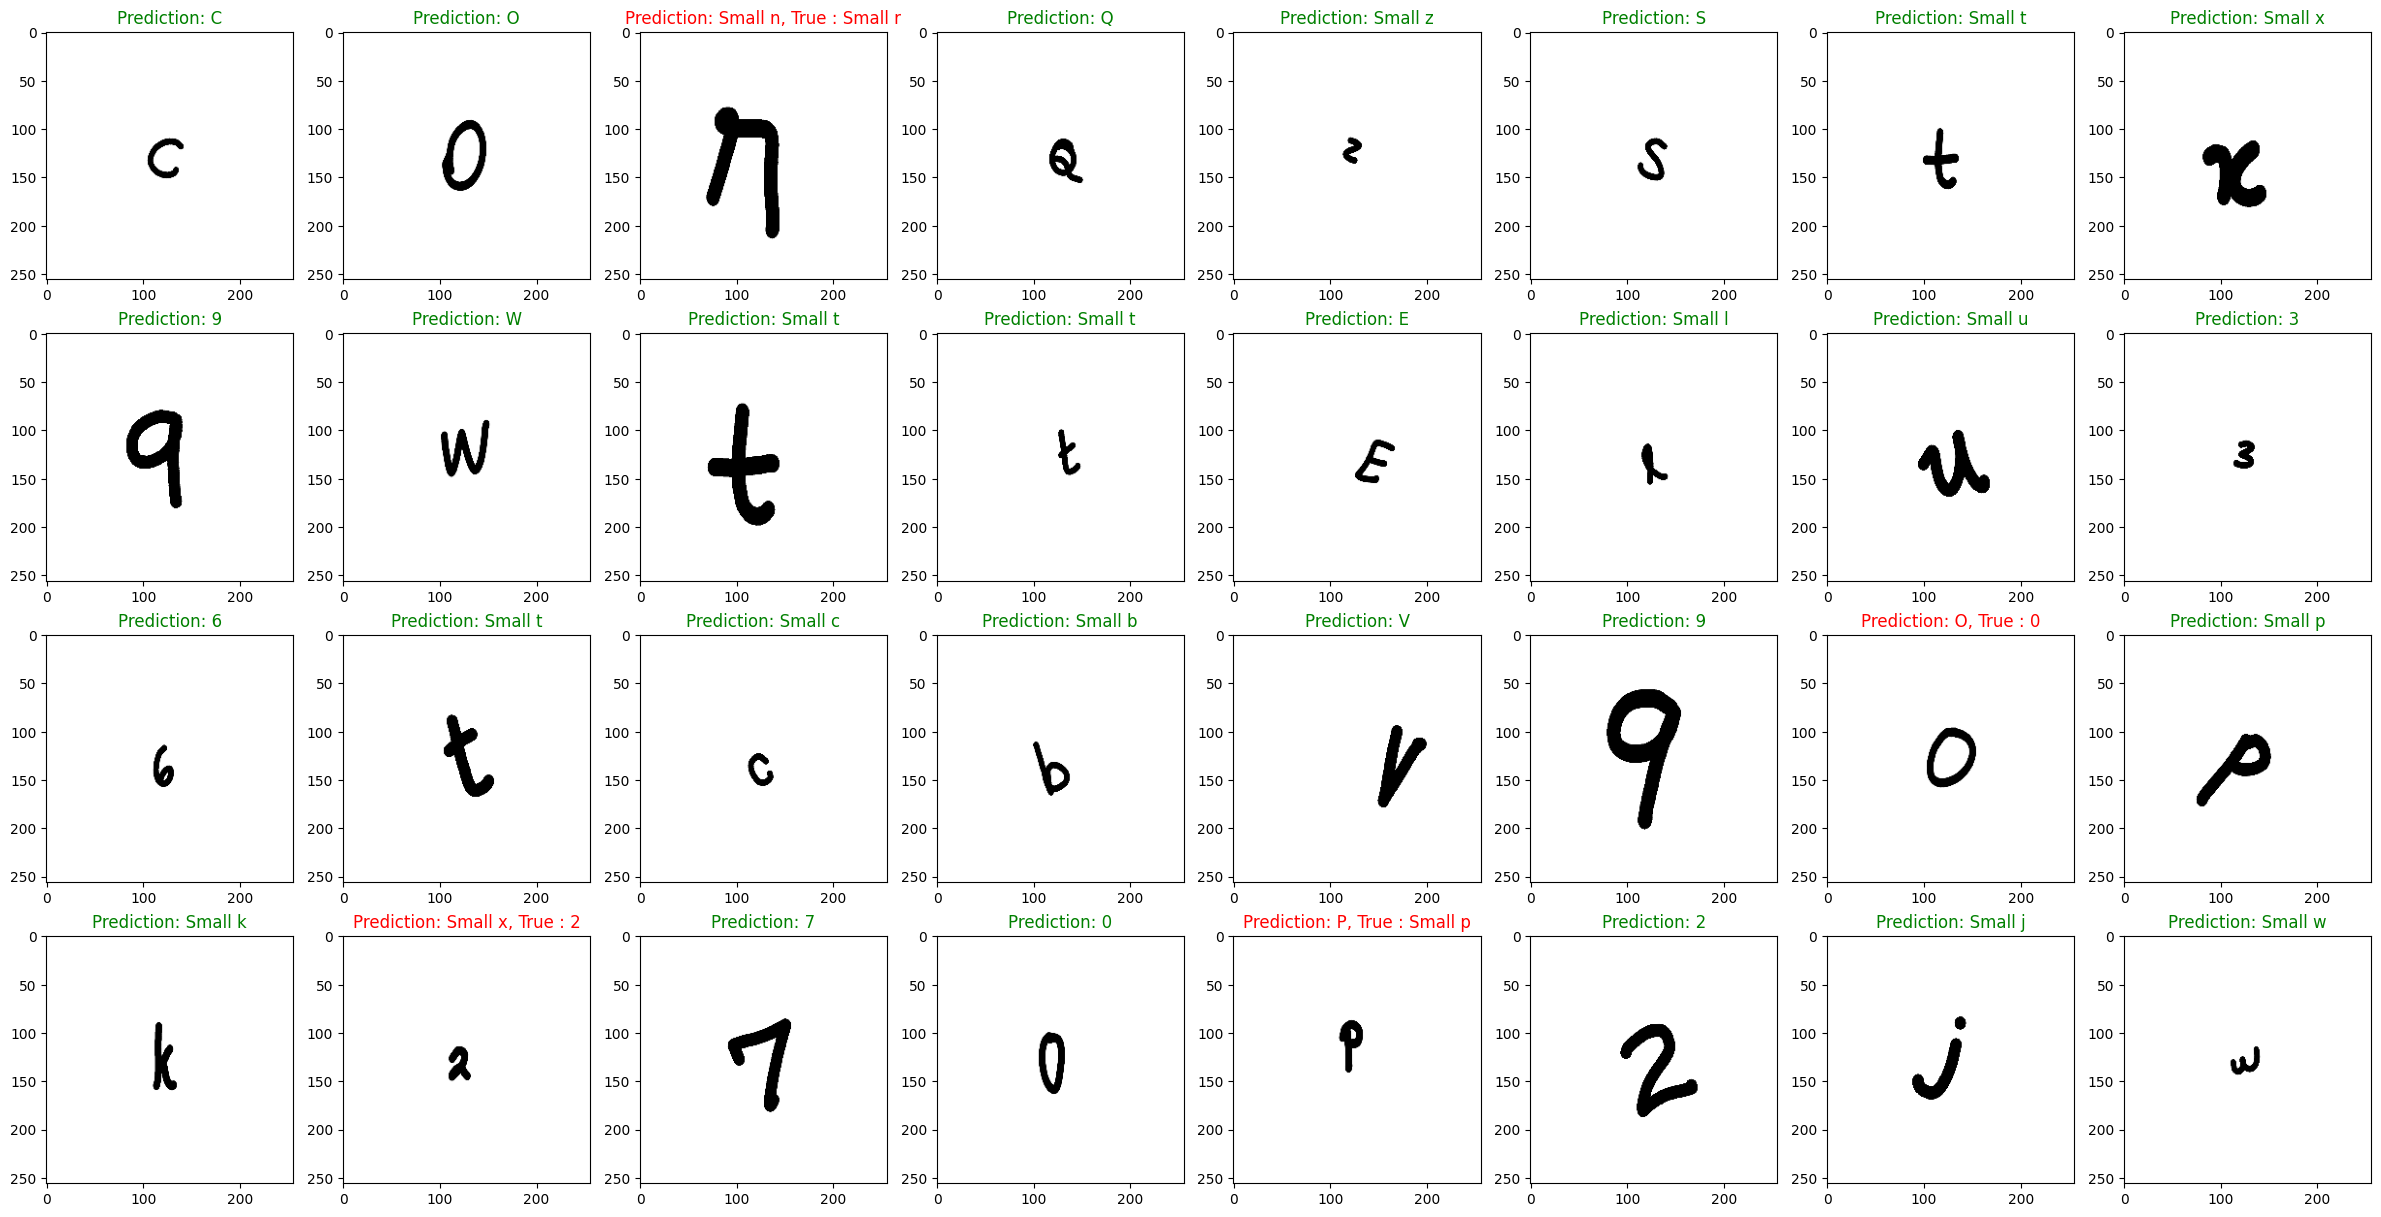

In [21]:
test_batch = val_ds.take(1)

for images,labels in test_batch:
    img_data = images
    target_labels = labels

fig,axes = plt.subplots(4,8)
fig.set_figwidth(30)
fig.set_figheight(15)

tot = 0
for i in range(4):
    for j in range(8):
        display_predictions(img_data,target_labels,tot,axes[i][j])
        tot += 1